# Transfer Learning avec Bert

## Librairies

In [69]:
!pip install tensorflow

In [70]:
!pip install transformers

In [48]:
import pickle
import warnings
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from transformers import BertTokenizer, BertModel
from transformers import TFBertModel
from transformers import TFBertForSequenceClassification
import tensorflow as tf
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix
import keras

## Settings

In [2]:
warnings.filterwarnings('ignore')
plt.style.use('dark_background')

sav_path = "./sav/"

## Fonctions usuelles

In [3]:
def save_to_file(sav_path, filename, var):
    path_to_file = sav_path + filename
    pickle.dump(var, open(path_to_file, "wb"))
    return

def plot_metrics(model_history):
    plt.figure()
    plt.plot(model_history.history['accuracy'])
    plt.plot(model_history.history['val_accuracy'])
    plt.legend(['Train', 'Validation'])
    plt.title("Accuracy en fonction du nombre d'epochs")
    plt.show()
    
    plt.figure()
    plt.plot(model_history.history['loss'])
    plt.plot(model_history.history['val_loss'])
    plt.legend(['Train', 'Validation'])
    plt.title("Loss en fonction du nombre d'epochs")
    plt.show()

## Importation des données

In [4]:
X = pickle.load(open(sav_path+"X.sav", "rb"))
y = pickle.load(open(sav_path+"y.sav", "rb"))

In [5]:
for dataset in X:
    ls_empty = np.where(X[dataset] == "")
    X[dataset] = np.delete(X[dataset], ls_empty)
    y[dataset] = np.delete(y[dataset], ls_empty)

## BERT

### Tokenisation

In [7]:
num_classes = 2
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased',num_labels=num_classes)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [78]:
bert_tokenizer.save_pretrained(sav_path+"bert_tok/")

('./sav/bert_tok/tokenizer_config.json',
 './sav/bert_tok/special_tokens_map.json',
 './sav/bert_tok/vocab.txt',
 './sav/bert_tok/added_tokens.json')

In [79]:
MAX_LEN = 128
def tokenize(tweets):
    input_ids=[]
    attention_masks=[]
    for tweet in tweets:
        bert_inp=bert_tokenizer.encode_plus(
            tweet,
            add_special_tokens=True,
            max_length=MAX_LEN,
            pad_to_max_length=True,
            return_attention_mask=True
        )
        input_ids.append(bert_inp["input_ids"])
        attention_masks.append(bert_inp["attention_mask"])
    inputs_ids = np.array(input_ids)
    attention_masks = np.array(attention_masks)
    return input_ids, attention_masks

In [80]:
input_ids = {}
attention_masks = {}

for dataset in X:
    print("Tokenisation de {}...".format(dataset))
    input_ids[dataset], attention_masks[dataset] = tokenize(
        X[dataset]
    )

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Tokenisation de data...
Tokenisation de cmp...
Tokenisation de val...
Tokenisation de train...
Tokenisation de train_smpl...
Tokenisation de test...


In [81]:
save_to_file(sav_path, "bert_input_ids.sav", input_ids)
save_to_file(sav_path, "bert_attention_masks.sav", attention_masks)

In [8]:
input_ids = pickle.load(open(sav_path+"bert_input_ids.sav", "rb"))
attention_masks = pickle.load(open(sav_path+"bert_attention_masks.sav", "rb"))

### Création du modèle

In [9]:
log_dir="tensorboard_data_3/tbert"
model_save_path=sav_path+"chckpnt/"

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=model_save_path,
        save_weights_only=True,
        monitor='val_loss',
        mode='min',
        save_best_only=True
    ),
    keras.callbacks.TensorBoard(log_dir=log_dir)]

print('\nBert Model',bert_model.summary())

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5,epsilon=1e-08)

bert_model.compile(
    loss=loss,
    optimizer=optimizer,
    metrics=[metric]
)

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 109,483,778
Trainable params: 109,483,778
Non-trainable params: 0
_________________________________________________________________

Bert Model None


### Entraînement

In [10]:
train_inp = np.array(input_ids["train_smpl"])
train_mask= np.array(attention_masks["train_smpl"])
train_labels = np.array(y["train_smpl"])
val_inp = np.array(input_ids["val"])
val_mask= np.array(attention_masks["val"])
val_labels = np.array(y["val"])
batch_size=32
epochs=4

history = bert_model.fit(
    [
        train_inp,
        train_mask
    ],
    train_labels,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(
        [
            val_inp,
            val_mask
        ],
        val_labels
    ),
    callbacks=callbacks
)

Epoch 1/4
250/250 [==============================] - 5424s 22s/step - loss: 0.5059 - accuracy: 0.7441 - val_loss: 0.4082 - val_accuracy: 0.8185
Epoch 2/4
250/250 [==============================] - 5247s 21s/step - loss: 0.3190 - accuracy: 0.8704 - val_loss: 0.4429 - val_accuracy: 0.8143
Epoch 3/4
250/250 [==============================] - 5257s 21s/step - loss: 0.1683 - accuracy: 0.9351 - val_loss: 0.5373 - val_accuracy: 0.8013
Epoch 4/4
250/250 [==============================] - 5255s 21s/step - loss: 0.0943 - accuracy: 0.9691 - val_loss: 0.6071 - val_accuracy: 0.8125


In [11]:
bert_model.save(sav_path+"BERT_model_3")

INFO:tensorflow:Assets written to: ./sav/BERT_model_3\assets


INFO:tensorflow:Assets written to: ./sav/BERT_model_3\assets


In [28]:
bert_model.save_weights(sav_path+'BERT_WEIGHTS/bert_model_weights', save_format='tf')

In [ ]:
with open(sav_path+"BERT_history.sav", "wb") as file_pi:
    pickle.dump(history.history, file_pi)

### Evaluation

In [12]:
result_bert = bert_model.predict(
    [
        val_inp,
        val_mask
    ]
)

1560/1560 [==============================] - 3442s 2s/step


In [13]:
y_pred_bert = np.argmax(result_bert["logits"], axis=1)

In [42]:
def conf_matrix(y, y_pred, title):
    fig, ax =plt.subplots(figsize=(5,5))
    labels=[0, 1]
    ax=sns.heatmap(
        confusion_matrix(y, y_pred), 
        annot=True, 
        cmap="Blues", 
        fmt='g', 
        cbar=False, 
        annot_kws={"size":25}
    )
    plt.title(title, fontsize=20)
    ax.set_ylabel('Test', fontsize=20)
    ax.set_xlabel('Predicted', fontsize=20)
    plt.show()

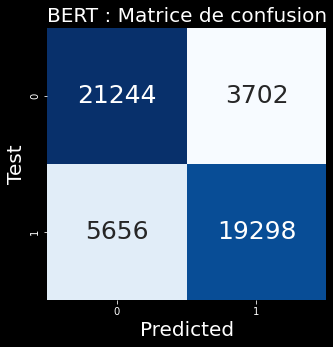

In [15]:
conf_matrix(y["val"], y_pred_bert, "BERT : Matrice de confusion")

#### Accuracy et Loss

In [49]:
accuracy_bert = accuracy_score(y["val"], y_pred_bert)
print("accuracy : ", accuracy_bert)

accuracy :  0.8124649298597194


In [16]:
print(classification_report(y["val"], y_pred_bert))

              precision    recall  f1-score   support

           0       0.79      0.85      0.82     24946
           1       0.84      0.77      0.80     24954

    accuracy                           0.81     49900
   macro avg       0.81      0.81      0.81     49900
weighted avg       0.81      0.81      0.81     49900



In [46]:
bert_model.evaluate(
    [
        np.array(input_ids["cmp"]),
        np.array(attention_masks["cmp"])
    ],
    np.array(y["cmp"]),
    verbose=2
)

50/50 - 134s - loss: 0.6294 - accuracy: 0.7999 - 134s/epoch - 3s/step


[0.6293730735778809, 0.7998745441436768]

In [17]:
def plot_metrics(model_history):
    plt.figure()
    plt.plot(model_history.history['accuracy'])
    plt.plot(model_history.history['val_accuracy'])
    plt.legend(['Train', 'Validation'])
    plt.title("Accuracy en fonction du nombre d'epochs")
    plt.show()
    
    plt.figure()
    plt.plot(model_history.history['loss'])
    plt.plot(model_history.history['val_loss'])
    plt.legend(['Train', 'Validation'])
    plt.title("Loss en fonction du nombre d'epochs")
    plt.show()

In [18]:
history.history

{'loss': [0.5059288144111633,
  0.3189660906791687,
  0.16831812262535095,
  0.09430529177188873],
 'accuracy': [0.7440521121025085,
  0.870398223400116,
  0.9351364970207214,
  0.9690708518028259],
 'val_loss': [0.4082324802875519,
  0.44289740920066833,
  0.537297785282135,
  0.6070894002914429],
 'val_accuracy': [0.8185170292854309,
  0.8143486976623535,
  0.8012825846672058,
  0.8124649524688721]}

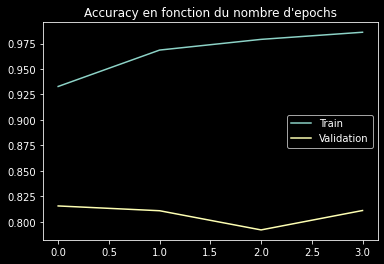

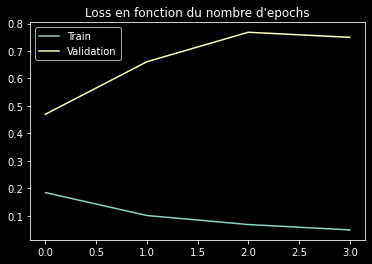

In [86]:
plot_metrics(history)

## Test du modèle sauvegardé

In [26]:
def load_saved_model(checkpoint_path):
    model = TFBertForSequenceClassification.from_pretrained(
        'bert-base-uncased',
        num_labels=2
    )
    loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True
    )
    metric = tf.keras.metrics.SparseCategoricalAccuracy(
        'accuracy'
    )
    optimizer = tf.keras.optimizers.Adam(
        learning_rate=2e-5,
        epsilon=1e-08
    )
    model.compile(
        loss=loss,
        optimizer=optimizer,
        metrics=[metric]
    )
    model.load_weights(checkpoint_path)
    return model

In [27]:
def tokenize_txt(txt, bert_tokenizer):
    MAX_LEN = 128
    input_ids=[]
    attention_masks=[]
    bert_inp=bert_tokenizer.encode_plus(
        txt,
        add_special_tokens=True,
        max_length=MAX_LEN,
        pad_to_max_length=True,
        return_attention_mask=True,
        truncation=True
    )
    input_ids.append(bert_inp["input_ids"])
    attention_masks.append(bert_inp["attention_mask"])
    inputs_ids = np.array(input_ids)
    attention_masks = np.array(attention_masks)
    return input_ids, attention_masks

In [ ]:
def predict_from_text(txt, tokenizer, model):
    i, a = tokenize_txt(txt, tokenizer)
    res = model.predict([i, a])
    prediction = np.argmax(rest["logits"], axis=1)
    return prediction

In [40]:
loaded_model = load_saved_model(sav_path+'BERT_WEIGHTS/bert_model_weights')

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [41]:
# loaded_model.load_weights(sav_path+'BERT_WEIGHTS/bert_model_weights')
result_loaded_model = loaded_model.predict(
    [
        val_inp,
        val_mask
    ]
)

1560/1560 [==============================] - 4138s 3s/step


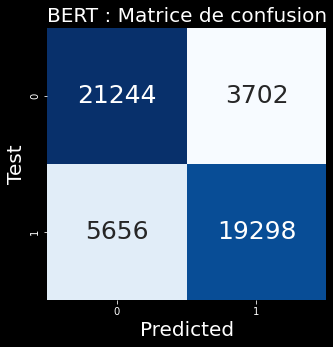

In [44]:
y_pred_loaded_model = np.argmax(result_loaded_model["logits"], axis=1)
conf_matrix(y["val"], y_pred_loaded_model, "BERT : Matrice de confusion")